In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import quandl
import pandas

In [2]:
def getPortfolio(stocks=['AAPL','AMZN','GOOGL','FB','AAL','AMGN']):
    # An example of stocks you can pick
    # You may find the symbols at:
    # https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_Component_Stocks
    # Apple, Amazon, Google, Facebook, American Airlines, Amgen Inc. 
    # ['AAPL','AMZN','GOOGL','FB','AAL','AMGN']
    
    # You need an API key to use the quandl API
    # the key below is mine, use wisely! (I can see your requests O_O)
    # We may ran out of API requests so you might
    # have to create a free account at: https://www.quandl.com/
    # you can find your key at: https://www.quandl.com/account/profile
    # This is my API key
    quandl.ApiConfig.api_key = 'mms1QX5xHzFq9PQH3zms'

    # Get stock closing time values from 2009 to 2019
    data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                            qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                            date = { 'gte': '2009-1-1', 'lte': '2019-1-1' }, paginate=True)
    data.head()
    df = data.set_index('date')
    stock_table = df.pivot(columns='ticker')
    # By specifying col[1] in below list comprehension
    # You can select the stock names under multi-level column
    stock_table.columns = [col[1] for col in stock_table.columns]
    stock_table.head()
    return stock_table

In [3]:
def portfolioReader(filename):
    #######################
    # Skip the comments
    #######################
    def skipComments(idx,content):
        while content[idx][0]=='#':
            idx += 1
            continue
        return idx
    #######################
    with open(filename) as f:
        read_data = f.read().split('\n')
    f.closed
    idx = 0
    idx = skipComments(idx,read_data)
    # define arrays
    N = int(read_data[idx].strip())
    idx += 1
    ret = np.zeros(N)
    sdv = np.zeros(N)
    covariance_mat = np.zeros([N,N])
    idx = skipComments(idx,read_data)
    # populate return and sdv
    # Problem:ret_sdv
    for ii in range (0,N):
        # read the contents into the 2 np.arrays
        stock = read_data[idx+ii].lstrip().split(' ')
        ret[ii] = float(stock[0])
        sdv[ii] = float(stock[1])
    idx += N
    idx = skipComments(idx,read_data)
    # populate the cov
    # Yahoo finance explains how:
    # https://finance.yahoo.com/news/calculating-covariance-stocks-170000325.html
    while read_data[idx][0] != '#':
            II,JJ,VAL = read_data[idx].strip().split(' ')
            # Problem:cov
            covariance_mat[int(II)-1,int(JJ)-1] = float(VAL)*sdv[int(II)-1]*sdv[int(JJ)-1]
            idx += 1
    return N,ret,sdv,covariance_mat

In [4]:
def portfolioWriter(filename,table,market='S&P 500'):
    f = open(filename,'w')
    f.write('#######################\n')
    f.write('# Market: ' + market +'\n')
    f.write('# Dates: ' + str(table.index[0])+' '+str(table.index[-1])+'\n')
    f.write('# Socks: '+np.array2string(table.columns).replace("\n","")+'\n')
    f.write('#######################\n')
    f.write(' '+str(len(table.columns))+'\n')
    f.write('#######################\n')
    f.closed
    # Problem:get_mean_returns
    # calculate the returns
    r = get_returns(table)
    returns = r.apply(lambda x: x.mean()).values
    # Problem:get_stds
    # calculate the standard deviation
    stds = r.apply(lambda x: x.std()).values
    for i in range(0,len(returns)):
        f.write(' '+str(returns[i])+' '+str(stds[i])+'\n')
    f.write('#######################\n')
    # Problem:corr
    # calculate the correlation matrix
    corrMat = r.corr().values
    for (ii,jj), x in np.ndenumerate(corrMat):
        f.write(' ' + str(ii+1)+' '+str(jj+1)+' '+str(x)+'\n')
    f.write('#######################\n')

In [5]:
def plotPrices(stock_table,fontsize=12,figsize=(14, 7)):
    # If you have issues with '%matplotlib inline' and '%config..'
    # you can just save the image with plt.savefig('plotPrices.png')
    plt.style.use('fivethirtyeight')
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.figure(figsize=figsize)
    for c in stock_table.columns.values:
        plt.plot(stock_table.index, stock_table[c], lw=3, alpha=0.8,label=c)
    plt.legend(loc='upper left', fontsize=fontsize)
    plt.ylabel('price in $')

In [6]:
def get_returns(d):
    s = d.copy()
    return pandas.DataFrame((s[1:].values-s[:s.shape[0]-1].values)/s[:s.shape[0]-1].values,index = s.index[1:], columns = s.columns)
    
def plotReturns(stock_table,fontsize=12,figsize=(10, 5)):
    # Problem:get_returns
    # calculate the returns
    returns = get_returns(stock_table)
    plt.figure(figsize=figsize)
    for c in returns.columns.values:
        plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
    plt.legend(loc='lower right', fontsize=fontsize)
    plt.ylabel('daily returns')

In [7]:
#########################################################################
# Reading Writing and Visuaizing the portfolio!!!
#########################################################################

In [8]:
# Use judiciously you only need this for your extra credt!!! (I am watching you O_O)
# stock_table = getPortfolio()
dateparse = lambda x: pandas.datetime.strptime(x, '%Y-%m-%d')
stock_table = pandas.read_csv('stock_table.csv',index_col='date',date_parser=dateparse)

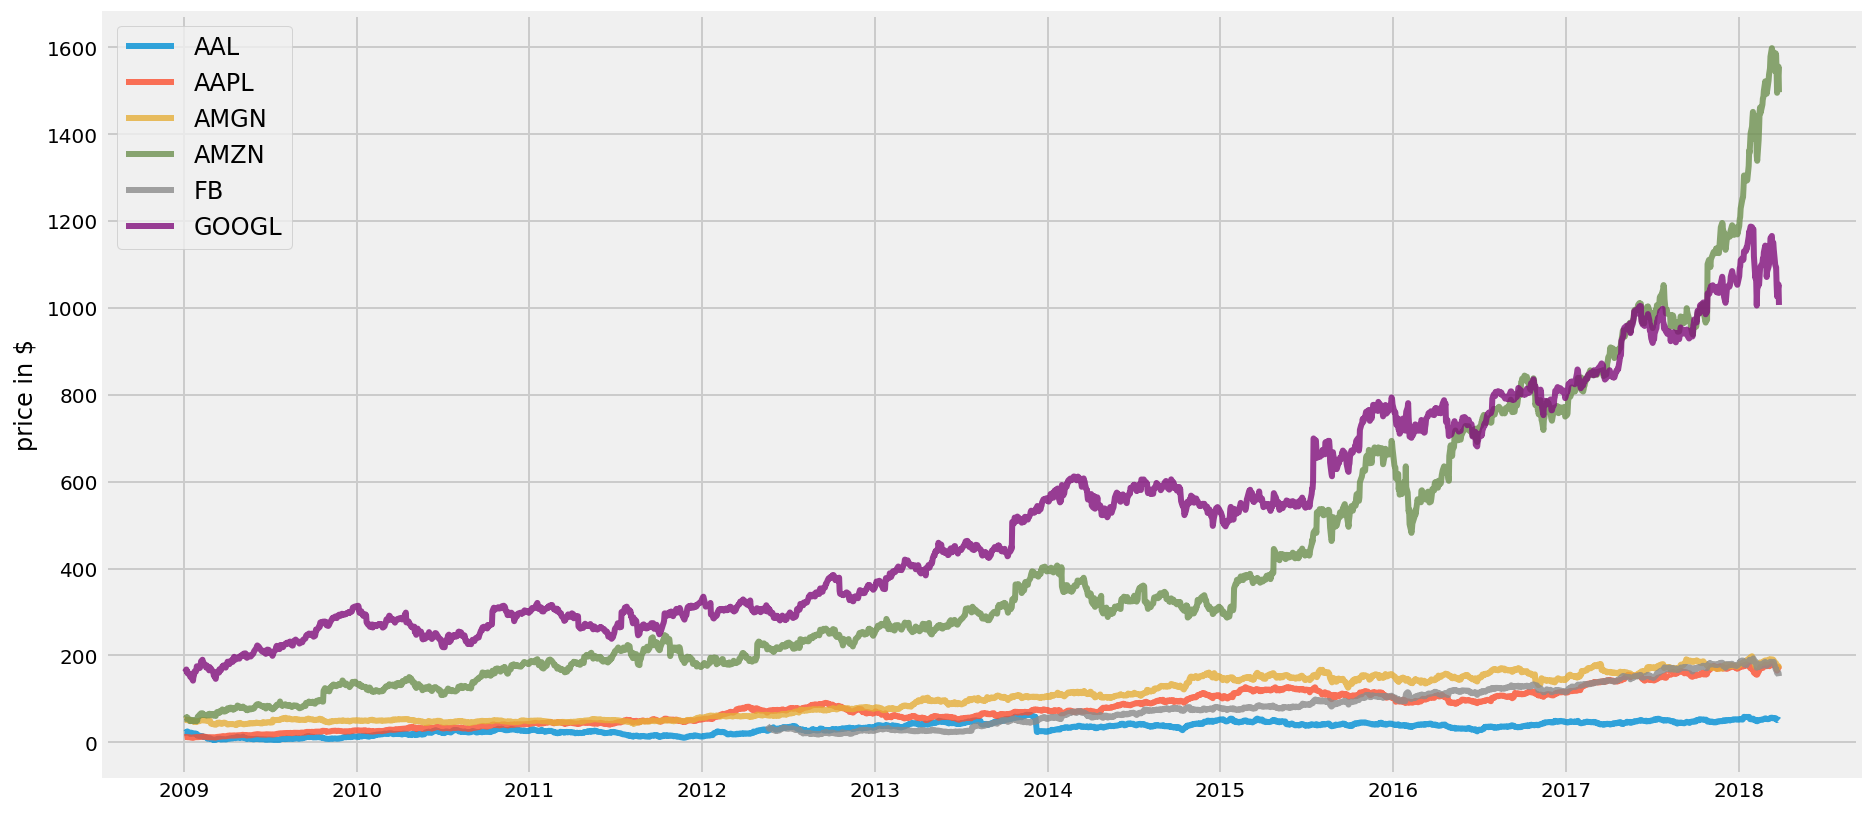

In [9]:
plotPrices(stock_table)

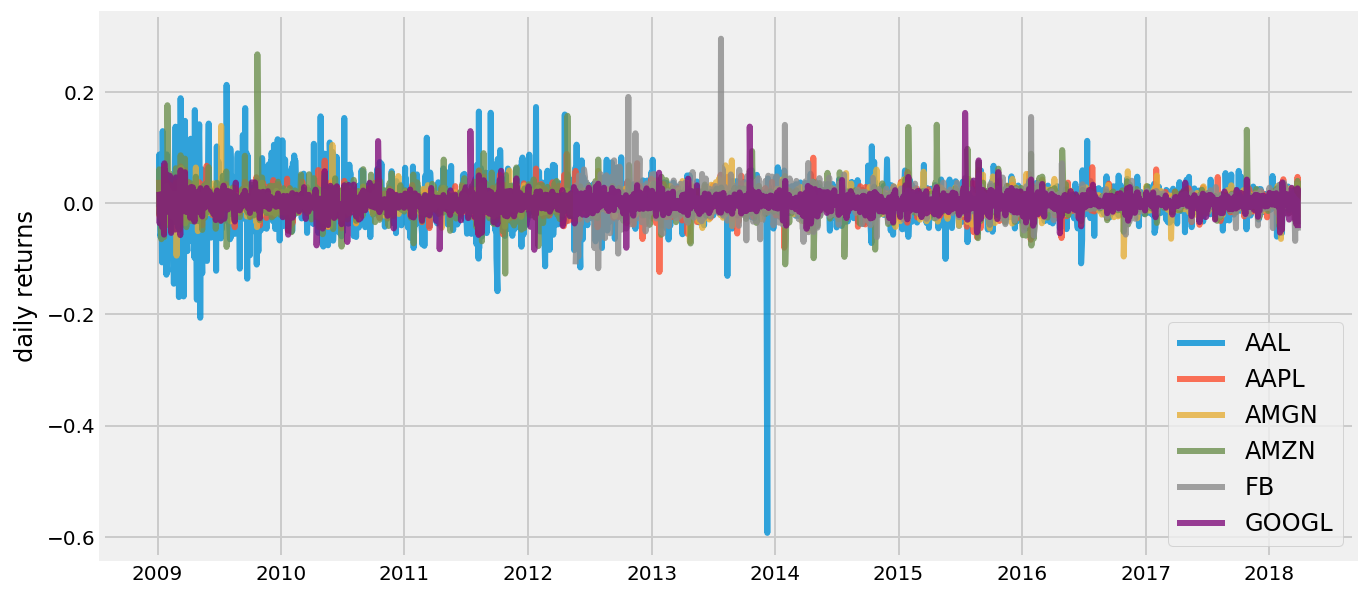

In [10]:
plotReturns(stock_table)

In [11]:
portfolioWriter('myport.in',stock_table)

In [12]:
N,expected_ret,sdv_arr,covariance_mat = portfolioReader('./myport.in')

In [13]:
#########################################################################
# portfolio Optimization!!!
#########################################################################

In [14]:
def portOpt(prob,SAMPLES = 100):
    # Compute trade-off curve.
    risk_data = np.zeros(SAMPLES)
    ret_data = np.zeros(SAMPLES)
    gamma_vals = np.logspace(-2, 3, num=SAMPLES)
    solutions = []
    for i in range(SAMPLES):
        gamma.value = gamma_vals[i]
        prob.solve(warm_start=False)
        risk_data[i] = cp.sqrt(risk).value
        ret_data[i] = ret.value
        solutions.append(np.copy(w.value))
    return risk_data,ret_data,gamma_vals,solutions

In [15]:
stock_symbols = ['AAPL','AMZN','GOOGL','FB','AAL','AMGN']
#stock_symbols = [str(ii) for ii in range(1,N+1)]

In [16]:
#######################
# No holds bar
#######################
w = cp.Variable(N)
gamma = cp.Parameter(nonneg=True)
# Problem:ret
# ret is the expected return for the portfolio, how would you calculate that?
ret = (expected_ret).T*w
# Problem:risk
# risk is the cov matrix for the portfolio, how would you calculate that?
risk = 0
# Problem:constraint_1
# write the constraints for long only holds
constraints = [sum(w) == 1]
objective = cp.Maximize(ret)
prob = cp.Problem(objective,constraints)

In [17]:
prob.solve(warm_start=False)
ret.value

1440.9120216964916

In [18]:
w.value

array([  -21050.52742949,   347027.46270158, -1208085.58298761,
        1256449.72414232,   168306.31431026,  -542646.39073705])

In [19]:
#######################
# Long holds only!!!!
#######################
w = cp.Variable(N)
gamma = cp.Parameter(nonneg=True)
# Problem:ret
# ret is the expected return for the portfolio, how would you calculate that?
ret = (expected_ret).T*w
# Problem:risk
# risk is the risk cov matrix for the portfolio, how would you calculate that?
risk = 0
# Problem:constraints_long_hold
# write the constraints for long only holds
constraints = [sum(w) == 1 , w >= 0 ]
objective = cp.Maximize(ret)
prob = cp.Problem(objective,constraints)

In [20]:
prob.solve(warm_start=False)
ret.value

0.001655363191717547

In [21]:
w.value

array([-2.09023488e-28, -2.09115547e-28, -2.08726895e-28,  1.00000000e+00,
       -2.09070866e-28, -2.08892910e-28])

In [22]:
#######################
# Long holds + risk
#######################
w = cp.Variable(N)
gamma = cp.Parameter(nonneg=True)
# Problem:ret
# ret is the expected return for the portfolio, how would you calculate that?
ret = (expected_ret).T*w
# Problem:risk
# risk is the risk cov matrix for the portfolio, how would you calculate that?
risk = cp.quad_form(w,covariance_mat)
# Problem:constraints_long_hold
# write the constraints for long only holds
constraints = [sum(w) == 1 , w >= 0 ]
# Problem:objective_1
# write the constraints for long only holds
objective = cp.Maximize(ret - gamma*risk)
prob = cp.Problem(objective,constraints)

In [23]:
risk_data,ret_data,gamma_vals,solutions = portOpt(prob)

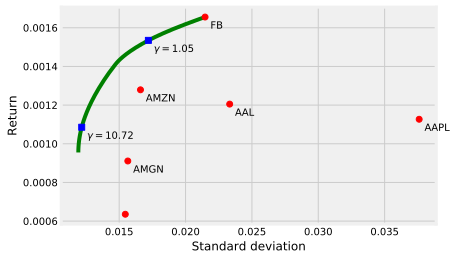

In [24]:
# Plot long only trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [40, 60]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate("$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+0.0004, ret_data[marker]-0.00006))
for i in range(N):
    plt.plot(cp.sqrt(covariance_mat[i,i]).value, expected_ret[i], 'ro')
    ax.annotate(stock_symbols[i], xy=(np.sqrt(covariance_mat[i,i])+0.0004, expected_ret[i]-0.00006))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

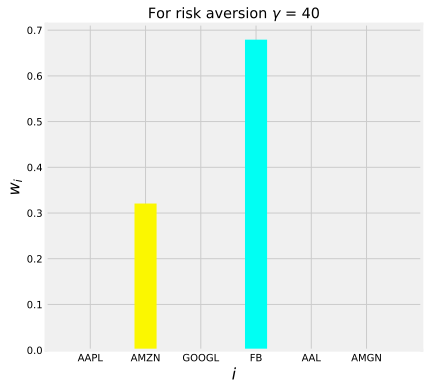

[1.50376654e-22 3.20772730e-01 1.48000393e-22 6.79227270e-01
 1.26425679e-22 7.89050104e-23]


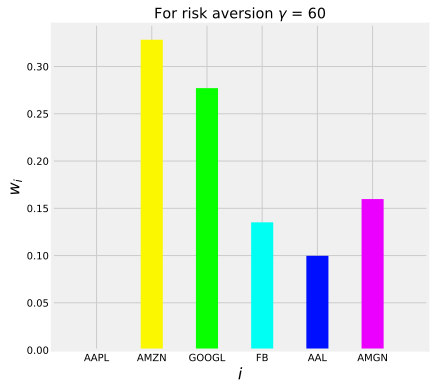

[-1.09837835e-23  3.28313281e-01  2.77103424e-01  1.35102035e-01
  9.97224969e-02  1.59758763e-01]


In [25]:
for marker in markers_on:
    colors = ['b', 'g', 'r']
    plt.figure(figsize=(6,6))
    plt.title('For risk aversion $\gamma$ = %.0f' % marker)
    newList = solutions[marker]+[0]
    plt.bar(np.arange(1,N+1), newList, width = 0.4, \
            tick_label=stock_symbols,
            color=[plt.cm.get_cmap('hsv', N+1)(ii) for ii in range(0,N+1)])
    plt.ylabel(r"$w_i$", fontsize=16)
    plt.xlabel(r"$i$", fontsize=16)
    plt.xlim([0.2, 2])
    plt.xticks(np.arange(1,N+2))
    plt.show()
    print(solutions[marker])

In [26]:
#######################
# Maximum leverage constraints
# if you loose in everything, how much 
# will you have to pay?
#######################
w = cp.Variable(N)
Lmax =  cp.Parameter(nonneg=True)
gamma = cp.Parameter(nonneg=True)
# Problem:ret
# ret is the expected return for the portfolio, how would you calculate that?
ret = (expected_ret).T*w
# Problem:risk
# risk is the cov matrix for the portfolio, how would you calculate that?
risk = cp.quad_form(w,covariance_mat)
# Problem:constraints_maximum_leverage
# write the constraints for long only holds
constraints = [cp.norm(w, 1) <= Lmax]
# Problem:objective_1
# write the constraints for long only holds
objective = cp.Maximize(ret - gamma*risk)
prob = cp.Problem(objective,constraints)

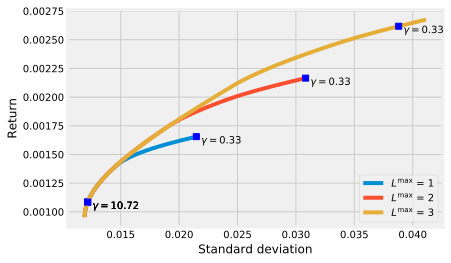

In [27]:
# Plot long only trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [30, 60]
fig = plt.figure()
ax = fig.add_subplot(111)
for Lmax in [1,2,3]:
    # Problem:constraints_maximum_leverage
    constraints = [sum(w) == 1, cp.norm(w, 1) <= Lmax]
    prob = cp.Problem(objective,constraints)
    risk_data,ret_data,gamma_vals,solutions = portOpt(prob)
    plt.plot(risk_data, ret_data, label=r"$L^{\max}$ = %d" % Lmax)
    for marker in markers_on:
        plt.plot(risk_data[marker], ret_data[marker], 'bs')
        ax.annotate("$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+0.0004, ret_data[marker]-0.00006))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.legend(loc='lower right')
plt.show()

In [28]:
#########################################################################
# Optimization with transaction costs
#########################################################################

In [29]:
X = [1/N] * N
A = [0.01]*N
B = [0.01]*N

In [30]:
x = np.asarray(X)
a = np.asarray(A)
b = np.asarray(B)
LU = 1
d = 0.000000001

In [31]:
w = cp.Variable(N)
gamma = cp.Parameter(nonneg=True)
# Problem:risk_costs
risk = cp.quad_form(w+x,covariance_mat)
# Problem:ret_costs
ret = (expected_ret).T*(w+x)
# Problem:constraints_costs
constraints = [sum((b/LU+a)*cp.abs(w))+sum(w) <= 0,w <= LU , w >= -LU]
objective = cp.Maximize(ret-gamma*risk)
problem = cp.Problem(objective, constraints)

In [32]:
SAMPLES = 10
upper_risk_data = np.zeros(SAMPLES)
upper_ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
solutions = []
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    problem.solve()
    upper_risk_data[i] = cp.sqrt(risk).value
    upper_ret_data[i] = ret.value
    solutions.append(np.copy(w.value))

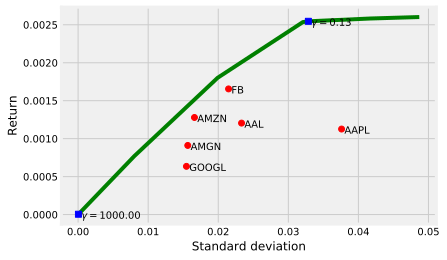

In [33]:
# Plot long only trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [2,9]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(upper_risk_data, upper_ret_data, 'g-')
for marker in markers_on:
    plt.plot(upper_risk_data[marker], upper_ret_data[marker], 'bs')
    ax.annotate("$\gamma = %.2f$" % gamma_vals[marker], xy=(upper_risk_data[marker]+0.0004, upper_ret_data[marker]-0.00006))
for i in range(N):
    plt.plot(cp.sqrt(covariance_mat[i,i]).value, expected_ret[i], 'ro')
    ax.annotate(stock_symbols[i], xy=(np.sqrt(covariance_mat[i,i])+0.0004, expected_ret[i]-0.00006))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [34]:
###########################
# Lower bound
###########################
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
Max_Iterations = 50
for i in range(SAMPLES):
    w = cp.Variable(N)
    gamma = cp.Parameter(nonneg=True)
    # Problem:risk_costs
    risk = cp.quad_form(w+x,covariance_mat)
    # Problem:ret_costs
    ret = (expected_ret).T*(w+x)
    # Problem:constraints_costs
    constraints = [sum((b/LU+a)*cp.abs(w))+sum(w) <= 0,w <= LU , w >= -LU]
    objective = cp.Maximize(ret-gamma*risk)
    problem = cp.Problem(objective, constraints)
    gamma.value = gamma_vals[i]
    problem.solve(warm_start=False)
    w_prev = np.copy(w.value)
    Keep_Going = True
    k = 0
    while Keep_Going == True and k <= Max_Iterations:
        k += 1
        # Problem:constraints_costs_lower
        constraints = [sum((b/(cp.abs(w_prev)+d)+a)*cp.abs(w))+sum(w) <= 0,w <= LU , w >= -LU]
        objective = cp.Maximize(ret-gamma*risk)
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.SCS, use_indirect=True, verbose=False)
        Keep_Going = (np.linalg.norm(w.value-w_prev,2) > d)
        w_prev=np.array(w.value, copy=True)
        risk_data[i] = cp.sqrt(risk).value
        ret_data[i] = ret.value
    if k > Max_Iterations:
        risk_data[i] = 0
        ret_data[i] = 0

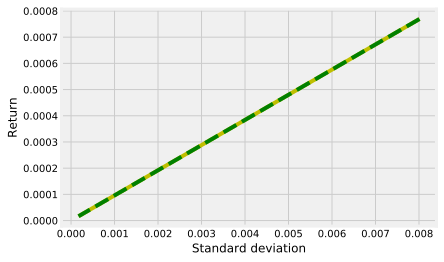

In [35]:
# Plot long only trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [5,8]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data[5:9], ret_data[5:9], 'y-')
plt.plot(upper_risk_data[5:9], upper_ret_data[5:9], 'g--')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [36]:
dif = upper_risk_data[5:9] - risk_data[5:9]
print(dif)
print(np.average(dif))

[ 2.53595750e-08  3.80668840e-09 -6.55696918e-09  2.30866205e-08]
1.1423978672052838e-08


### Extra Credit 


In [37]:
sp500 = pandas.read_csv('./constituents_csv.csv')
sp500

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ACN,Accenture plc,Information Technology
5,ATVI,Activision Blizzard,Information Technology
6,AYI,Acuity Brands Inc,Industrials
7,ADBE,Adobe Systems Inc,Information Technology
8,AAP,Advance Auto Parts,Consumer Discretionary
9,AMD,Advanced Micro Devices Inc,Information Technology


In [38]:
allStocks = sp500.Symbol.values.tolist()

In [39]:
# Run once this is huge
#big = getPortfolio(allStocks[0:10])
#for i in range(10,len(allStocks),10):
#    j = i + 10 if i + 10 <= len(allStocks) else len(allStocks)
#    print(j)
#    t = getPortfolio(allStocks[i:j])
#    big = pandas.concat([big,t], axis=1, sort=False)

In [40]:
#big

In [41]:
#big.to_csv('./allStock.csv')

In [42]:
big = pandas.read_csv('allStock.csv',index_col='date',date_parser=dateparse)

In [43]:
big

,AAP,ABBV,ABT,ACN,ADBE,AMD,AOS,ATVI,AYI,MMM,...,WYNN,XEL,XL,XLNX,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,33.243503,NaN,20.205231,27.866977,23.02,2.380,6.670047,8.336705,32.512156,47.137046,...,31.327203,13.320781,3.165197,14.701042,27.367609,NaN,19.029195,39.629992,23.874525,NaN
2009-01-05,32.795583,NaN,19.858165,27.991124,23.13,2.670,6.638920,7.998483,33.044836,46.587552,...,34.551091,13.193513,3.051283,14.604957,29.065837,NaN,19.546552,38.813861,23.234688,NaN
2009-01-06,32.844270,NaN,19.209304,27.643511,24.22,2.780,6.856808,7.477439,32.801859,47.137046,...,36.519776,13.023821,3.319795,14.901220,29.719002,NaN,19.510872,39.535094,24.017773,NaN
2009-01-07,31.539457,NaN,19.103676,27.958018,24.23,2.660,6.803448,8.300140,32.166381,46.245113,...,31.201683,12.889482,3.417436,14.324709,28.510647,NaN,18.815117,38.253953,21.563471,NaN
2009-01-08,31.646569,NaN,19.314933,27.676617,24.29,2.740,6.867925,8.464680,31.671083,46.651261,...,30.686389,13.059174,3.523214,13.612076,28.869888,NaN,18.725918,39.278865,21.200579,NaN
2009-01-09,30.945476,NaN,19.303616,27.916636,24.01,2.690,6.761204,8.464680,30.755247,45.982312,...,29.094264,12.896553,3.498804,13.059586,28.510647,NaN,18.208561,39.753362,20.799486,NaN
2009-01-12,30.020422,NaN,18.884874,27.337281,23.76,2.520,6.721184,8.318422,29.316077,45.456709,...,27.085941,12.981398,3.018736,12.771330,27.008368,NaN,18.149095,38.975188,19.882705,NaN
2009-01-13,30.302807,NaN,19.020682,28.198037,22.10,2.380,7.010219,8.373269,28.970303,44.795723,...,25.916621,12.783425,3.059419,12.995529,27.465583,NaN,17.774458,38.889778,20.923634,NaN
2009-01-14,29.338804,NaN,18.796507,26.848967,21.11,2.150,6.658930,8.281858,27.353573,43.832117,...,23.967755,12.705650,2.807180,12.411011,25.865329,NaN,17.179795,38.462730,20.045051,NaN


In [44]:
recent = big.copy().tail(50).dropna(axis=1).columns

In [45]:
# Extra credit says we cannot invest in aerospace, defense or tobacco
probablyAerospace = sp500[sp500["Sector"]=="Industrials"].Symbol.tolist()

In [46]:
small = big.copy()[recent].drop(columns = probablyAerospace,errors="ignore")
small = small.drop(columns=['GGP','MO'])

In [47]:
r = get_returns(small)
returns = pandas.DataFrame(r.apply(lambda x: x.mean()),columns=["return"])

In [48]:
stds = pandas.DataFrame(r.apply(lambda x: x.std()),columns=["sdv"])

In [49]:
lookAt = pandas.concat([returns,stds],axis=1, sort=False)

In [50]:
f = 0.92
lookAt["factor"] = lookAt.apply(lambda x: f*x["return"] - (1-f)*x["sdv"], axis=1)

In [51]:
smallSorted = lookAt.sort_values("factor", ascending=False)
smallSorted

,return,sdv,factor
TPR,0.002743,0.015285,0.001301
DXC,0.001743,0.013088,0.000556
SPGI,0.001237,0.011899,0.000186
HLT,0.000931,0.011462,-0.000061
CMS,0.000828,0.011176,-0.000132
NI,0.000969,0.013010,-0.000149
AAPL,0.001277,0.016609,-0.000154
HD,0.001040,0.013930,-0.000157
ROST,0.001151,0.015536,-0.000184
TJX,0.001017,0.014213,-0.000202


In [52]:
newCol = smallSorted[:10].index
stock_symbols = newCol

In [53]:
top10 = big[newCol]

In [54]:
portfolioWriter('top10port.in',top10)

In [55]:
N,expected_ret,sdv_arr,covariance_mat = portfolioReader('./top10port.in')

In [56]:
N

10

In [57]:
#######################
# Long holds + risk
#######################
w = cp.Variable(N)
gamma = cp.Parameter(nonneg=True)
# Problem:ret
# ret is the expected return for the portfolio, how would you calculate that?
ret = (expected_ret).T*w
# Problem:risk
# risk is the risk cov matrix for the portfolio, how would you calculate that?
risk = cp.quad_form(w,covariance_mat)
# Problem:constraints_long_hold
# write the constraints for long only holds
constraints = [sum(w) == 1 , w >= 0 ]
# Problem:objective_1
# write the constraints for long only holds
objective = cp.Maximize(ret - gamma*risk)
prob = cp.Problem(objective,constraints)

In [58]:
risk_data,ret_data,gamma_vals,solutions = portOpt(prob)

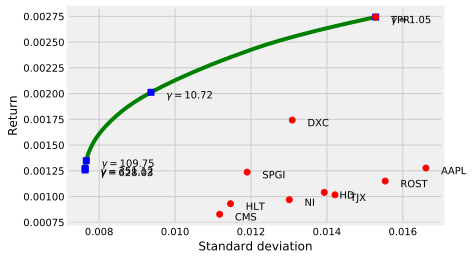

In [59]:
# Plot long only trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [40, 60, 80, 90, 95]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate("$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+0.0004, ret_data[marker]-0.00006))
for i in range(N):
    plt.plot(cp.sqrt(covariance_mat[i,i]).value, expected_ret[i], 'ro')
    ax.annotate(stock_symbols[i], xy=(np.sqrt(covariance_mat[i,i])+0.0004, expected_ret[i]-0.00006))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

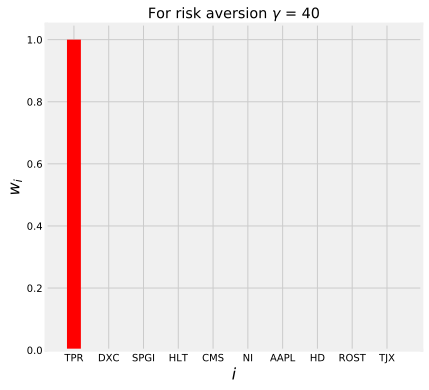

[ 1.00000000e+00 -1.11274313e-22  5.54057348e-23 -2.01288587e-25
  2.21577834e-22  5.52995985e-23  5.60664338e-23  1.11557273e-22
  1.11459884e-22  1.11333462e-22]


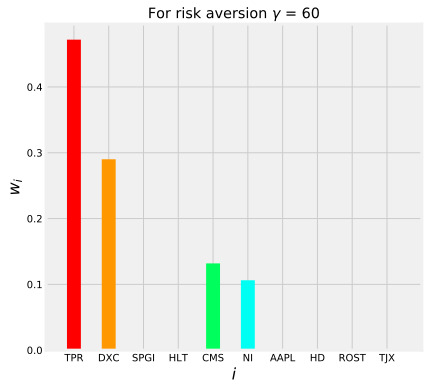

[4.71914727e-01 2.90084876e-01 1.42164306e-22 8.09493454e-23
 1.31815342e-01 1.06185056e-01 2.56555806e-23 2.34449701e-23
 2.70222226e-23 7.61745638e-24]


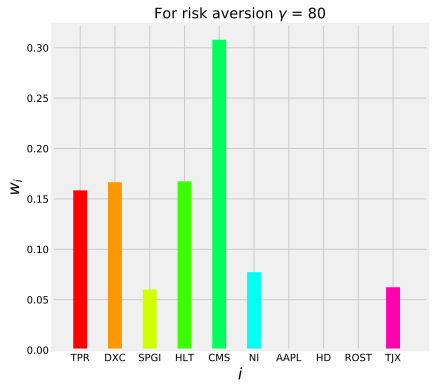

[ 1.58448159e-01  1.66471736e-01  6.01244034e-02  1.67455064e-01
  3.07916999e-01  7.72570630e-02 -2.72033838e-23 -2.56416863e-23
 -2.47702625e-24  6.23265754e-02]


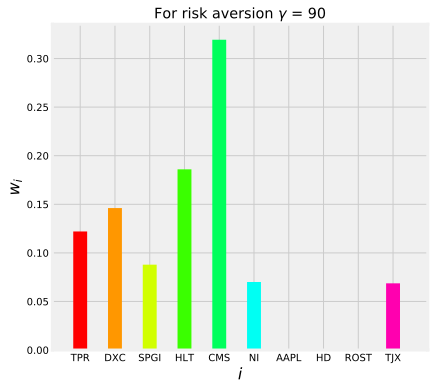

[ 1.22033247e-01  1.46111873e-01  8.78443777e-02  1.85978597e-01
  3.19319039e-01  7.00535661e-02 -7.43325104e-24  1.25247609e-23
  1.10539234e-23  6.86592998e-02]


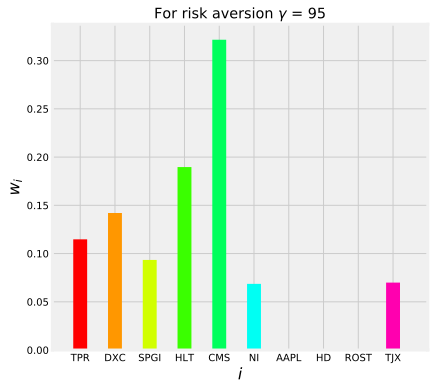

[ 1.14732621e-01  1.42030036e-01  9.34018030e-02  1.89692279e-01
  3.21604972e-01  6.86093765e-02 -6.79140628e-23  1.32323726e-23
 -6.57840749e-23  6.99289129e-02]


In [60]:
for marker in markers_on:
    colors = ['b', 'g', 'r']
    plt.figure(figsize=(6,6))
    plt.title('For risk aversion $\gamma$ = %.0f' % marker)
    newList = solutions[marker]+[0]
    plt.bar(np.arange(1,N+1), newList, width = 0.4, \
            tick_label=stock_symbols,
            color=[plt.cm.get_cmap('hsv', N+1)(ii) for ii in range(0,N+1)])
    plt.ylabel(r"$w_i$", fontsize=16)
    plt.xlabel(r"$i$", fontsize=16)
    plt.xlim([0.2, 2])
    plt.xticks(np.arange(1,N+2))
    plt.show()
    print(solutions[marker])

In [61]:
stock_symbols

Index(['TPR', 'DXC', 'SPGI', 'HLT', 'CMS', 'NI', 'AAPL', 'HD', 'ROST', 'TJX'], dtype='object')

In [62]:
gamma = 80

In [63]:
solutions[gamma]

array([ 1.58448159e-01,  1.66471736e-01,  6.01244034e-02,  1.67455064e-01,
        3.07916999e-01,  7.72570630e-02, -2.72033838e-23, -2.56416863e-23,
       -2.47702625e-24,  6.23265754e-02])